In [56]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from sklearn.metrics import pairwise

from tqdm import tqdm

In [3]:
DATA_DIR = 'data'

In [4]:
try:
    os.mkdir(os.path.join(DATA_DIR, 'preprocess'))
    os.mkdir(os.path.join(DATA_DIR, 'preprocess', 'training'))
    os.mkdir(os.path.join(DATA_DIR, 'preprocess', 'testing'))
except:
    pass

In [198]:
train_files = glob.glob(os.path.join(DATA_DIR, 'training', 'training', '*.png'))

In [6]:
def preprocess_image(filename):
    im = cv2.imread(filename)
    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(imgray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours_ = list(filter(lambda c: len(c) > 10, contours))
    
    new_image = np.zeros((300, 300, 3), np.float32)
    new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
    new_image = cv2.fillPoly(new_image, pts = contours_, color=(255))
    
    return new_image

In [16]:
for file in tqdm(train_files):
    im = preprocess_image(file)
    out_dir = os.path.join(DATA_DIR, 'preprocess', 'training')
    
    cv2.imwrite(os.path.join(out_dir, file.split('\\')[-1]), im)

100%|█████████████████████████████████████████████████████████████████████████████| 2313/2313 [00:19<00:00, 119.05it/s]


In [12]:
def get_keypoints(filename):
    img = cv2.imread(filename)
    img = cv2.resize(img, (416, 416))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    sift = cv2.SIFT_create()
    
    return sift.detectAndCompute(gray, None)

In [17]:
preprocess_files = glob.glob(os.path.join(DATA_DIR, 'preprocess', 'training', '*.png'))

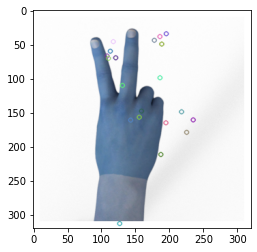

In [82]:
filename = train_files[6]

kp, des = get_keypoints(filename)
img = cv2.imread(filename)


plt.imshow(cv2.drawKeypoints(img, kp, None))
plt.show()

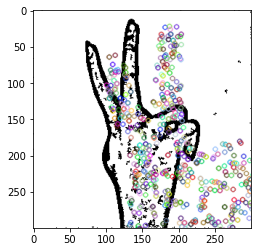

In [174]:

def count_fingers(filename):

    img = cv2.imread(filename)
#     img = cv2.copyMakeBorder(img, 10, 10, 10, 10, cv2.BORDER_CONSTANT, None, value = (255, 255, 255))

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _,img=cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    cont,hie=cv2.findContours(img,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    img2 = img.copy()

    con= sorted(cont,key=cv2.contourArea)[-2]


    conv_hull= cv2.convexHull(con)
    cv2.drawContours(img, [conv_hull],-1,150,3)
    
    
    top=np.array(conv_hull[conv_hull[:,:,1].argmin()][0])
    bottom=np.array(conv_hull[conv_hull[:,:,1].argmax()][0])
    left=np.array(conv_hull[conv_hull[:,:,0].argmin()][0])
    right=np.array(conv_hull[conv_hull[:,:,0].argmax()][0])
#     cx=(left[0]+right[0])//2
#     cy=(top[1]+bottom[1])//2

#     dist=pairwise.euclidean_distances([left,right,bottom,top],[[cx,cy]])[0]
    radi=int(0.4*np.linalg.norm(top-bottom))

    circular_roi=np.zeros_like(img,dtype='uint8')
    cv2.circle(circular_roi,(cx,cy),radi,255,8)
    wighted=cv2.addWeighted(img.copy(),0.6,circular_roi,0.4,2)

    mask=cv2.bitwise_and(img2,img2,mask=circular_roi)
    
    plt.imshow(cv2.addWeighted(img.copy(),0.6,circular_roi,0.4,2))
    plt.show()
    
    con,hie=cv2.findContours(mask.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    count=0
    circumfrence=2*np.pi*radi
    for cnt in con:
        count+=1
            
    return count

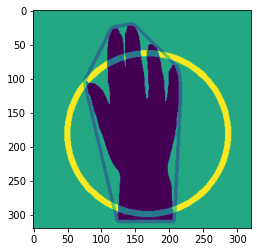

Fingers: 2


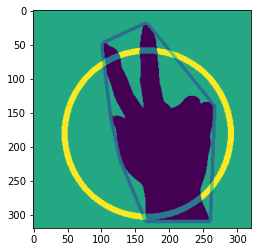

Fingers: 1


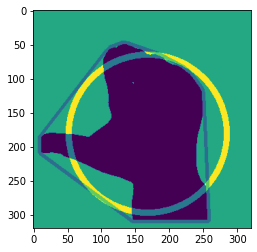

Fingers: 0


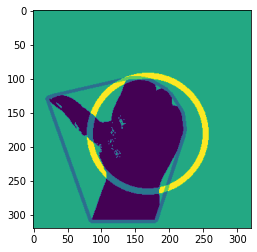

Fingers: 1


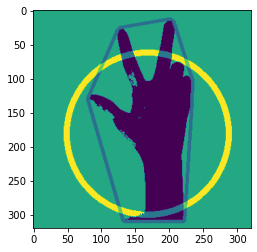

Fingers: 1


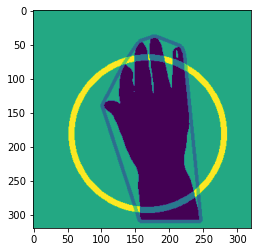

Fingers: 2


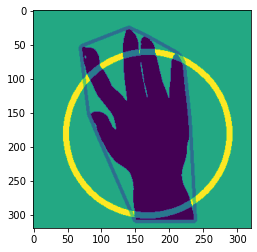

Fingers: 3


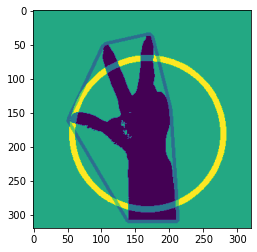

Fingers: 2


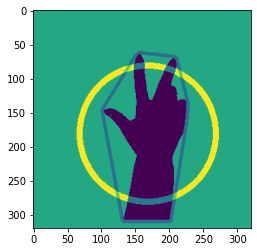

Fingers: 1


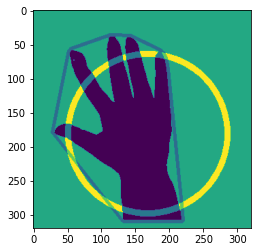

Fingers: 4


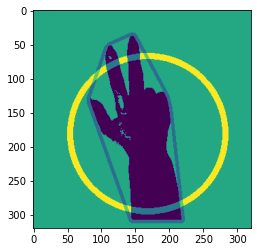

Fingers: 1


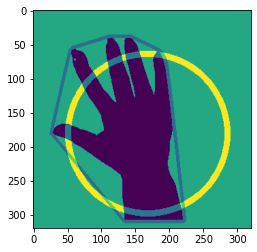

Fingers: 4


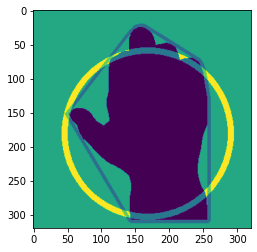

Fingers: 4


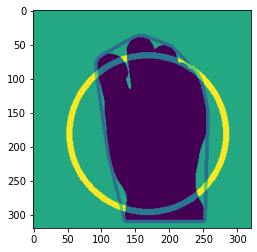

Fingers: 1


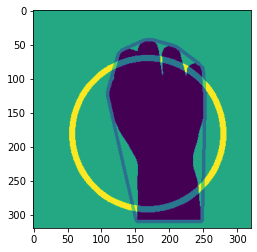

Fingers: 2


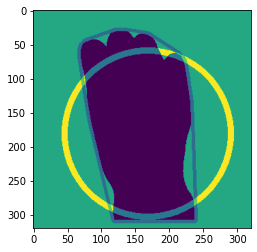

Fingers: 1


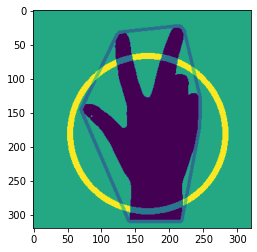

Fingers: 1


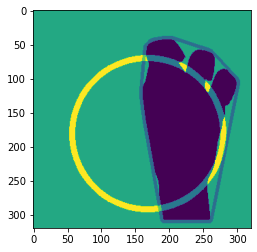

Fingers: 2


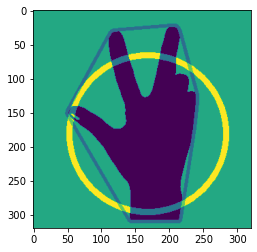

Fingers: 3


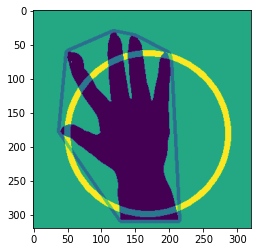

Fingers: 4


In [175]:

for i in range(30, 50):
    n_fingers = count_fingers(train_files[i])
    
    img = cv2.imread(train_files[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    print(f"Fingers: {n_fingers}")
    
    plt.show()



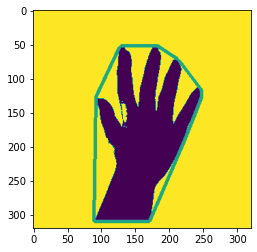

In [138]:
plt.imshow(img)

In [141]:
count

4

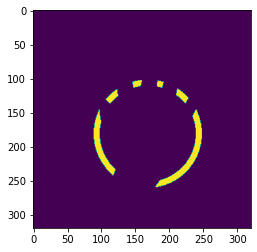

In [142]:
plt.imshow(cv2.bitwise_and(img2,img2,mask=circular_roi))

In [253]:
def preprocess_img(img):
    
    img = cv2.copyMakeBorder(img, 10, 10, 10, 10, cv2.BORDER_CONSTANT, None, value = (255, 255, 255))

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _,img=cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    img = cv2.resize(img, (28, 28))
    
    return img

def load_data(files):
    images = []
    for file in tqdm(files):
        img = cv2.imread(file)
        img = preprocess_img(img)
        images.append(img)
        
    return np.array(images)/255.0

images = load_data(train_files)
        
        

100%|█████████████████████████████████████████████████████████████████████████████| 2892/2892 [00:05<00:00, 515.18it/s]


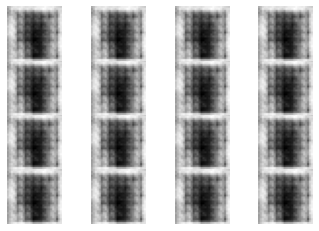

----------- EPOCH 6 -----------
17/91 [====>.........................] - ETA: 8s - loss: 0.0774

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input, Flatten,\
                                    Reshape, LeakyReLU as LR,\
                                    Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Conv2DTranspose, MaxPooling2D, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU
from matplotlib import pyplot as plt
from IPython import display # If using IPython, Colab or Jupyter
import numpy as np

x_train = images


# Plot image data from x_train
plt.imshow(x_train[0], cmap = "gray")
plt.show()
LATENT_SIZE = 10
# encoder = Sequential([
#     Flatten(input_shape = (28, 28)),
#     Dense(512),
#     LR(),
#     Dropout(0.5),
#     Dense(256),
#     LR(),
#     Dropout(0.5),
#     Dense(128),
#     LR(),
#     Dropout(0.5),
#     Dense(64),
#     LR(),
#     Dropout(0.5),
#     Dense(LATENT_SIZE),
#     LR()
# ])
# decoder = Sequential([
#     Dense(64, input_shape = (LATENT_SIZE,)),
#     LR(),
#     Dropout(0.5),
#     Dense(128),
#     LR(),
#     Dropout(0.5),
#     Dense(256),
#     LR(),
#     Dropout(0.5),
#     Dense(512),
#     LR(),
#     Dropout(0.5),
#     Dense(784),
#     Activation("sigmoid"),
#     Reshape((28, 28))
# ])

#ENCODER
inp = Input((28, 28,1))
e = Conv2D(32, (3, 3), activation='relu')(inp)
e = MaxPooling2D((2, 2))(e)
e = Conv2D(64, (3, 3), activation='relu')(e)
e = MaxPooling2D((2, 2))(e)
e = Conv2D(64, (3, 3), activation='relu')(e)
l = Flatten()(e)
l = Dense(3, activation='softmax')(l)

#DECODER
d = Dense(49, activation='softmax')(l)
d = Flatten()(d)
d = Reshape((7,7,1))(d)
d = Conv2DTranspose(64,(3, 3), strides=2, activation='relu', padding='same')(d)
d = BatchNormalization()(d)
d = Conv2DTranspose(64,(3, 3), strides=2, activation='relu', padding='same')(d)
d = BatchNormalization()(d)
d = Conv2DTranspose(32,(3, 3), activation='relu', padding='same')(d)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(d)


# img = Input(shape = (28, 28))
# latent_vector = encoder(img)
# output = decoder(latent_vector)
# model = Model(inputs = img, outputs = output)
# model.compile("nadam", loss = "binary_crossentropy")
# encoder = Model(inp, l)

model = Model(inp, decoded)
model.compile(optimizer="adam", loss="mse")


EPOCHS = 20
#Only do plotting if you have IPython, Jupyter, or using Colab
for epoch in range(EPOCHS):
    fig, axs = plt.subplots(4, 4)
    rand = x_train[np.random.randint(0, 2000, 16)].reshape((4, 4, 1, 28, 28))
    
    display.clear_output() # If you imported display from IPython
    
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(model.predict(rand[i, j])[0], cmap = "gray")
            axs[i, j].axis("off")
    
    plt.subplots_adjust(wspace = 0, hspace = 0)
    plt.show()
    print("-----------", "EPOCH", epoch, "-----------")
    model.fit(x_train, x_train)

In [269]:

encoder = Model(inp, l)
x_train_encoded = encoder.predict(x_train)


In [271]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(x_train_encoded)



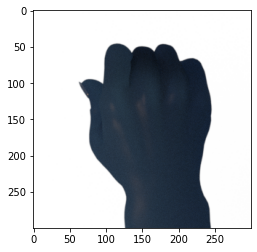

label: 1


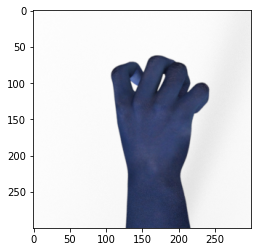

label: 2


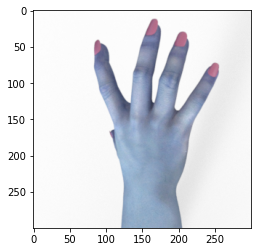

label: 0


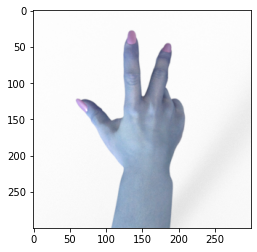

label: 0


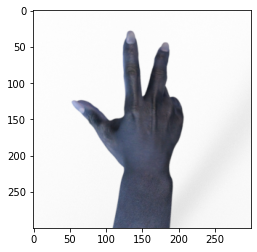

label: 0


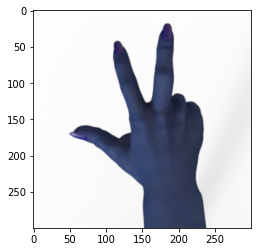

label: 2


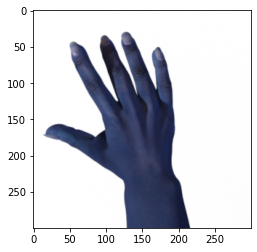

label: 0


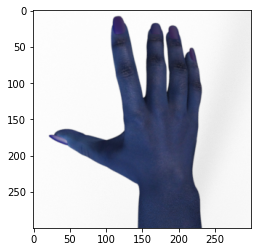

label: 2


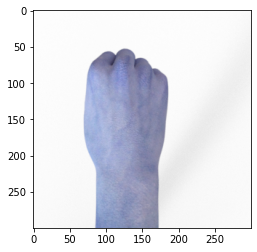

label: 0


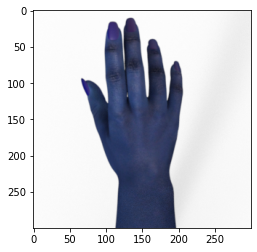

label: 0


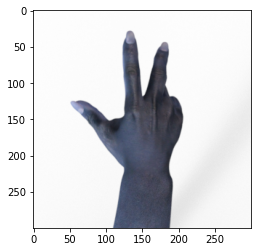

label: 0


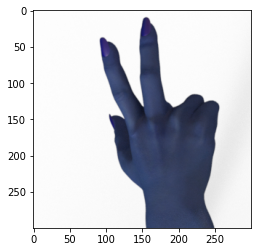

label: 2


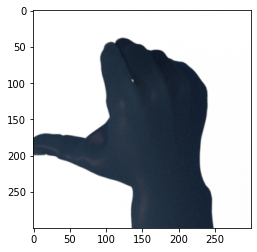

label: 2


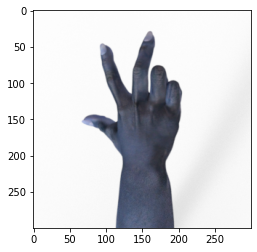

label: 0


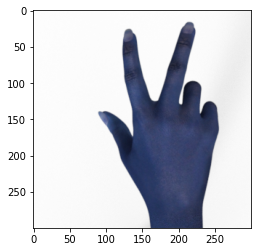

label: 2


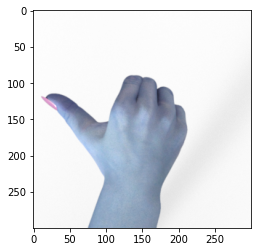

label: 2


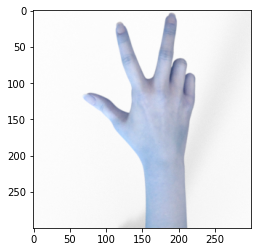

label: 1


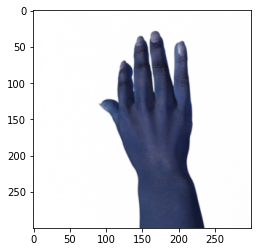

label: 2


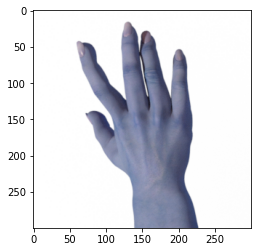

label: 2


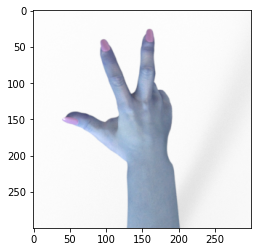

label: 0


In [272]:
for i in range(30, 50):
    
    img = cv2.imread(train_files[i])
    img_processed = preprocess_img(img)
    
    encoded_img = encoder.predict(img_processed.reshape(1,28,28))
    label = kmeans.predict(encoded_img)[0]
    
    plt.imshow(img)
    plt.show()
    print(f"label: {label}")
    

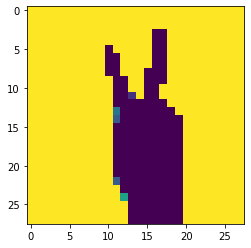

In [236]:
img = cv2.imread(train_files[12])

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_,img=cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
resized_image = cv2.resize(img, (28, 28)) 

plt.imshow(resized_image)

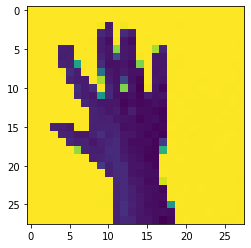

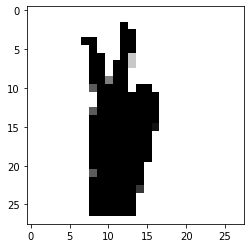

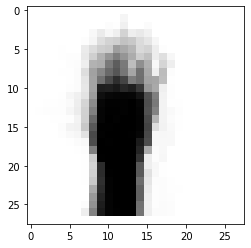

In [256]:
i = 10

plt.imshow(x_train[i].reshape((1, 28, 28))[0], cmap = "gray")
plt.show()
plt.imshow(model.predict(x_train[i].reshape((1, 28, 28)))[0], cmap = "gray")


